### **Phillies Baseball R&D Questionnaire**
Question B

In [20]:
#imports 

#Pandas dataframes
import pandas as pd

#Regular Expressions
import re

# Sqlite - simple database
import sqlite3

# For fetching/reading remote data
import urllib
import urllib.request
from urllib.request import urlopen

#for processing html
!pip3 install lxml
from lxml import etree
from bs4 import BeautifulSoup

#for visualizations
import matplotlib.pyplot as plt
import numpy as np
import math

Read in the Data 
 - using pandas read_html()

In [21]:
df = pd.read_html('https://questionnaire-148920.appspot.com/swe/data.html')[0]
df.head()

,Player,Salary,Year,Level
0,"Abreu, Jose","$11,666,667",2016,MLB
1,"Acevedo, Andury","$507,500",2016,MLB
2,"Ackley, Dustin","$3,200,000",2016,MLB
3,"Adames, Cristhian","$507,500",2016,MLB
4,"Adams, Austin","$507,500",2016,MLB


Clean the Data
 - Remove $ and ,'s from Salary
 - Seperate first and last name
 - Drop uneccesary columns

In [22]:
def clean_salary(x):
  y = re.sub("[^\d]", "", str(x))
  if (y.isnumeric()):
    return float(y)
  else:
    return None
    

#use apply to call the function over each element, returning a new Series
df['Salary'] = df['Salary'].apply(clean_salary)

#split first and last name 
df[['Lastname', 'Firstname']] = df['Player'].str.split(', ', expand=True)

#drop Year & Level 
df = df.drop(columns=['Year', 'Level', 'Player'])

df.head()

,Salary,Lastname,Firstname
0,11666667.0,Abreu,Jose
1,507500.0,Acevedo,Andury
2,3200000.0,Ackley,Dustin
3,507500.0,Adames,Cristhian
4,507500.0,Adams,Austin


Determine Qualifying Offer
 - Find the top 125 salaries 
 - Calculate their average

In [23]:
#find highest 125 salaries
#used as resource: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nlargest.html
top_salaries = df['Salary'].nlargest(n=125).to_frame()

#calculate mean of those salaries
qual_offer = top_salaries.mean()[0]

print("Qualifying offer: " + "${:,.2f}".format(qual_offer))

Qualifying offer: $16,644,594.14


Determine Qualifying Offer using SQL
 - using sqlite3
 - determine top 125 salaries
 - calculate average

In [24]:
#connect and convert from pandas dataframe to SQL database
conn = sqlite3.connect('local.db')
df.to_sql('salary_guide', con=conn, if_exists="replace")

query = '''SELECT AVG(Salary) as Qualifying_Offer
           FROM (SELECT Firstname, Lastname, Salary 
                FROM salary_guide 
                ORDER BY Salary DESC LIMIT 125 )'''
avg_df = pd.read_sql_query(query, conn)

qual_offer_sql = avg_df['Qualifying_Offer'][0]
print("Qualifying offer: " + "${:,.2f}".format(qual_offer_sql))


Qualifying offer: $16,644,594.14


Create visualizations to help determine if we should present our departing free agent with this qualifying offer by comparing their statisics to those of players with the top 125 salaries. 
 - scrape wikipedia for statistics using player's name
 - create dataframe with relevent statistics 
 - calculate averages based on player's position
 - create visualizations to help analyze this data

In [25]:
#create table with top 125 salaries and players
df.to_sql('salary_guide', con=conn, if_exists="replace")

query = '''SELECT Firstname, Lastname, Salary 
            FROM salary_guide 
            ORDER BY Salary DESC LIMIT 125'''
top_125_df = pd.read_sql_query(query, conn)

top_125_df.head()

,Firstname,Lastname,Salary
0,Clayton,Kershaw,34571429.0
1,Zack,Greinke,34000000.0
2,David,Price,30000000.0
3,Josh,Hamilton,28410000.0
4,Miguel,Cabrera,28000000.0


In [26]:
#used lelctures from UPenn's MCIT Course "545: Big Data Analytics" Modules 1 & 2 as resources for this section
#used as reference = https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html
crawl_list = []
pages = []
wiki_df = pd.DataFrame(columns = ['Firstname', 'Lastname', 'Wiki Page'])

#loop through top 125 players and create their wikipedia pages
for i, series in top_125_df.iterrows():
  url = 'https://en.wikipedia.org/wiki/' + top_125_df['Firstname'][i].replace(' ', '_') +  '_' + top_125_df['Lastname'][i].replace(' ', '_')
  crawl_list.append(url)
  # Some of the accent characters won't work, need to convert them into an HTML URL
  #split the URL, then use "parse.quote" to change the structure, then re-form the URL
  url_list = list(urllib.parse.urlsplit(url))
  url_list[2] = urllib.parse.quote(url_list[2])
  url_ascii = urllib.parse.urlunsplit(url_list)
  try:
    response = urllib.request.urlopen(url_ascii)
    #Save page and url for later use.
    pages.append(response)
  except urllib.error.URLError as e:
    #if unable to open the page, just add None 
    pages.append(None)
    #print(e.reason)
  
top_125_df['Wiki Page'] = crawl_list
top_125_df['url_response'] = pages
top_125_df.head()


,Firstname,Lastname,Salary,Wiki Page,url_response
0,Clayton,Kershaw,34571429.0,https://en.wikipedia.org/wiki/Clayton_Kershaw,<http.client.HTTPResponse object at 0x7fcb778c...
1,Zack,Greinke,34000000.0,https://en.wikipedia.org/wiki/Zack_Greinke,<http.client.HTTPResponse object at 0x7fcb77c3...
2,David,Price,30000000.0,https://en.wikipedia.org/wiki/David_Price,<http.client.HTTPResponse object at 0x7fcb77c3...
3,Josh,Hamilton,28410000.0,https://en.wikipedia.org/wiki/Josh_Hamilton,<http.client.HTTPResponse object at 0x7fcb77c3...
4,Miguel,Cabrera,28000000.0,https://en.wikipedia.org/wiki/Miguel_Cabrera,<http.client.HTTPResponse object at 0x7fcb77c3...


In [27]:
#create column headers for possible statistics 
top_125_df = pd.concat([top_125_df,pd.DataFrame(columns=['Position', 'Age', 'Earned run average', 'Strikeouts', 'Batting average', 'Home runs', 'Runs batted in'])])

In [28]:
#to avoid warning given
#https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

In [29]:
#loop through each player, scrape wikipedia page for relevant statistics 

for i, series in top_125_df.iterrows():  
    #make sure only reading pages that worked previously
    if (top_125_df['url_response'][i] != None):
      source = urlopen(top_125_df['Wiki Page'][i]).read()
      
      #create a DOM tree of the page
      tree = etree.HTML(source.decode("utf-8"))  

      #get player age
      age = tree.xpath('//table[contains(@class,"vcard")]//span[@class="noprint ForceAgeToShow"]/text()')
      if len(age) > 0:
        top_125_df['Age'][i] = int((age[0])[-3:-1])
  
      #get player position
      position = tree.xpath('//table[contains(@class,"vcard")]//td[@class="infobox-full-data"]//a/text()')      
      if len(position) > 1:
        if "pitcher" in str(position[0]).lower():
          top_125_df['Position'][i] = "Pitcher"
        else:
          top_125_df['Position'][i] = str(position[0])
      
      #get additional statistics ('Strikeouts', 'Home runs', 'Runs batted in', 'Earned run average', 'Batting average')
      stat_labels = tree.xpath('//table[contains(@class,"vcard")]//tr//th/a/text()')
      stat_data = tree.xpath('//table[contains(@class,"vcard")]//tr//td[contains(@class, "infobox-data")]/text()')

      row_headers_int = ['Strikeouts', 'Home runs', 'Runs batted in']
      row_headers_float = ['Earned run average', 'Batting average']

      #loop through labels found and if they are in the list above, add that data to the table
      for j in range(len(stat_labels)):
        if stat_labels[j] in row_headers_int:
          top_125_df[stat_labels[j]][i] = int(stat_data[j].replace(",",""))
        elif stat_labels[j] in row_headers_float:
          top_125_df[stat_labels[j]][i] = float(stat_data[j])

top_125_df.head()


,Firstname,Lastname,Salary,Wiki Page,url_response,Position,Age,Earned run average,Strikeouts,Batting average,Home runs,Runs batted in
0,Clayton,Kershaw,34571429.0,https://en.wikipedia.org/wiki/Clayton_Kershaw,<http.client.HTTPResponse object at 0x7fcb778c...,Pitcher,34,2.48,2702,NaN,NaN,NaN
1,Zack,Greinke,34000000.0,https://en.wikipedia.org/wiki/Zack_Greinke,<http.client.HTTPResponse object at 0x7fcb77c3...,Pitcher,38,3.41,2823,NaN,NaN,NaN
2,David,Price,30000000.0,https://en.wikipedia.org/wiki/David_Price,<http.client.HTTPResponse object at 0x7fcb77c3...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Josh,Hamilton,28410000.0,https://en.wikipedia.org/wiki/Josh_Hamilton,<http.client.HTTPResponse object at 0x7fcb77c3...,Outfielder,40,NaN,NaN,0.29,200,701
4,Miguel,Cabrera,28000000.0,https://en.wikipedia.org/wiki/Miguel_Cabrera,<http.client.HTTPResponse object at 0x7fcb77c3...,First baseman,39,NaN,NaN,0.31,505,1818


In [30]:
#general cleaning 

#drop wikipedia site - no longer needed
top_125_df = top_125_df.drop(columns = ['Wiki Page', 'url_response'])

#rename column headers - replace spaces with underscores
top_125_df.columns = top_125_df.columns.str.replace(' ','_')

In [31]:
#Use sqlite for table - will use for future queries
top_125_df.to_sql('top_125_stats', con=conn, if_exists="replace")
top_125_stats_sql = pd.read_sql_query('SELECT * FROM top_125_stats', conn)
top_125_stats_sql.head()

,index,Firstname,Lastname,Salary,Position,Age,Earned_run_average,Strikeouts,Batting_average,Home_runs,Runs_batted_in
0,0,Clayton,Kershaw,34571429.0,Pitcher,34.0,2.48,2702.0,NaN,NaN,NaN
1,1,Zack,Greinke,34000000.0,Pitcher,38.0,3.41,2823.0,NaN,NaN,NaN
2,2,David,Price,30000000.0,None,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Josh,Hamilton,28410000.0,Outfielder,40.0,NaN,NaN,0.29,200.0,701.0
4,4,Miguel,Cabrera,28000000.0,First baseman,39.0,NaN,NaN,0.31,505.0,1818.0


In [32]:
#serperate pitcher stats from other players
query = '''SELECT Firstname, Lastname, Position, Salary, Age, Earned_run_average, Strikeouts 
          FROM top_125_stats 
          WHERE Position = "Pitcher"'''
pitcher_stats = pd.read_sql_query(query, conn)
pitcher_stats.head()

,Firstname,Lastname,Position,Salary,Age,Earned_run_average,Strikeouts
0,Clayton,Kershaw,Pitcher,34571429.0,34,2.48,2702
1,Zack,Greinke,Pitcher,34000000.0,38,3.41,2823
2,Justin,Verlander,Pitcher,28000000.0,39,3.30,3054
3,Felix,Hernandez,Pitcher,25857143.0,36,3.42,2524
4,Jon,Lester,Pitcher,25000000.0,38,3.66,2488


In [33]:
#serperate pitcher stats from other players
query = '''SELECT Firstname, Lastname, Position, Salary, Age, Batting_average,	Home_runs,	Runs_batted_in
          FROM top_125_stats 
          WHERE Position != "Pitcher"'''
player_stats = pd.read_sql_query(query, conn)
player_stats

,Firstname,Lastname,Position,Salary,Age,Batting_average,Home_runs,Runs_batted_in
0,Josh,Hamilton,Outfielder,28410000.0,40,0.290,200,701
1,Miguel,Cabrera,First baseman,28000000.0,39,0.310,505,1818
2,Ryan,Howard,First baseman,25000000.0,42,0.258,382,1194
3,Albert,Pujols,First baseman,25000000.0,42,0.297,681,2155
4,Robinson,Cano,Second baseman,24000000.0,39,0.302,335,1305
...,...,...,...,...,...,...,...,...
63,Martin,Prado,Third baseman,11000000.0,38,0.287,100,609
64,Neil,Walker,Second baseman,10550000.0,36,0.267,149,609
65,Ben,Zobrist,Second baseman,10500000.0,40,0.266,167,768
66,Edwin,Encarnacion,Designated hitter,10000000.0,39,0.260,424,1261


In [34]:
#calculate averages stats for pitchers

query = '''SELECT Position, AVG(Salary) as Avg_Salary, AVG(Age) AS Avg_Age, AVG(Earned_run_average) as Avg_ERA, AVG(Strikeouts) AS Avg_Strikeouts
          FROM top_125_stats
          WHERE Position = "Pitcher"
          GROUP BY Position'''
avg_pitcher_stats = pd.read_sql_query(query, conn)
avg_pitcher_stats.head()

,Position,Avg_Salary,Avg_Age,Avg_ERA,Avg_Strikeouts
0,Pitcher,1.677003e+07,37.219512,3.633415,1681.731707


In [35]:
#calculate average stats remaining positions
query = '''SELECT Position, AVG(Salary) as Avg_Salary, AVG(Age) AS Avg_Age, AVG(Batting_average) as Avg_Batting_average, AVG(Home_runs) AS Avg_Home_runs, AVG(Runs_batted_in) as Avg_Runs_batted_in
          FROM top_125_stats
          WHERE Position != "None" and Position != "Pitcher"
          GROUP BY Position'''
avg_player_stats = pd.read_sql_query(query, conn)
avg_player_stats

,Position,Avg_Salary,Avg_Age,Avg_Batting_average,Avg_Home_runs,Avg_Runs_batted_in
0,Catcher,1.712963e+07,37.500000,0.273333,156.000000,753.833333
1,Center fielder,1.555655e+07,37.250000,0.280000,147.250000,587.000000
2,Designated hitter,1.341667e+07,42.000000,0.273667,472.666667,1428.000000
3,First baseman,2.040082e+07,39.000000,0.284800,370.400000,1239.900000
4,Left fielder,1.765179e+07,39.500000,0.285500,248.500000,972.250000
5,Outfielder,1.706463e+07,38.466667,0.265333,194.066667,693.333333
6,Right fielder,1.470833e+07,37.000000,0.263200,250.800000,909.600000
7,Second baseman,1.359643e+07,38.571429,0.281714,198.000000,855.857143
8,Shortstop,1.733333e+07,38.666667,0.278000,277.000000,1003.333333
9,Third baseman,1.466875e+07,37.750000,0.277625,244.625000,926.375000


###**Time to see the graphs!**

For each of the graphs below:
 - a **purple** line represents the qualifying offer
 - a **red** line represents the average for the statistic for that position
 - a **blue** line represents the line of best fit for the given scatter plot




In [36]:
def create_scatterplot(x, y, x_label, y_label, position, avg_x, avg_y):
  #create scatter plot with x & y data
  plt.scatter(x, y)
  
  #set titles/labels
  title = position + " " + x_label + " vs " + y_label
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  #create line of best fit
  m, b = np.polyfit(x, y, 1)
  plt.plot(x, m*x+b)

  #plot average point & lines for given position/stat
  plt.plot(avg_x,avg_y,'ro') 
  plt.axvline(x = avg_x, color = 'r')
  plt.axhline(y = avg_y, color = 'r')

  #plot qualifying offer
  plt.axhline(y = qual_offer/1000000, color = 'purple')

  #show the final graph
  plt.show()



First, the Pitchers: 

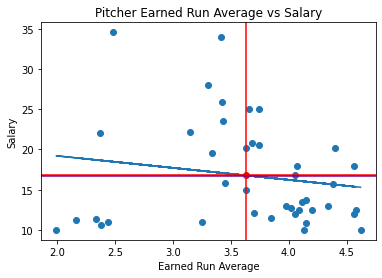

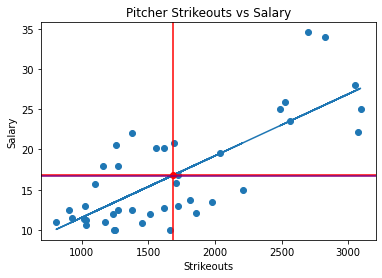

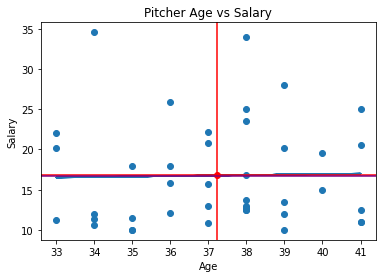

In [37]:
#ERA
create_scatterplot(pitcher_stats['Earned_run_average'], pitcher_stats['Salary']/1000000, "Earned Run Average", "Salary", "Pitcher", avg_pitcher_stats['Avg_ERA'][0], avg_pitcher_stats['Avg_Salary'][0]/1000000)
#Strikeouts
create_scatterplot(pitcher_stats['Strikeouts'], pitcher_stats['Salary']/1000000, "Strikeouts", "Salary", "Pitcher", avg_pitcher_stats['Avg_Strikeouts'][0], avg_pitcher_stats['Avg_Salary'][0]/1000000)
#Age
create_scatterplot(pitcher_stats['Age'], pitcher_stats['Salary']/1000000, "Age", "Salary", "Pitcher", avg_pitcher_stats['Avg_Age'][0], avg_pitcher_stats['Avg_Salary'][0]/1000000)


Then, the remaining positions:

Catcher


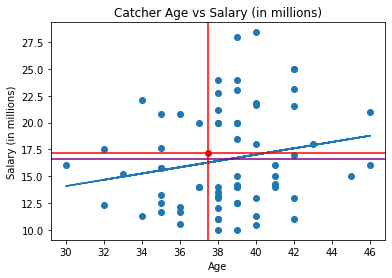

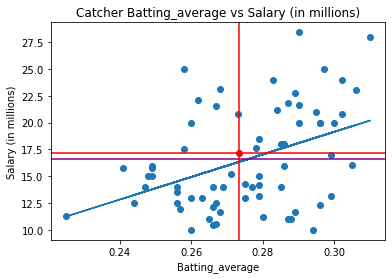

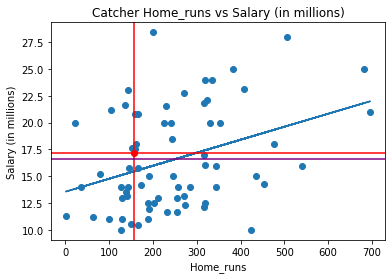

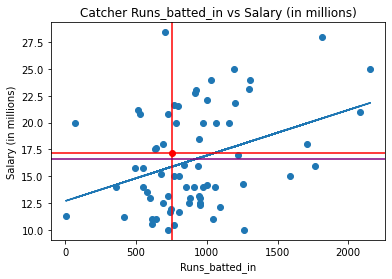



Center fielder


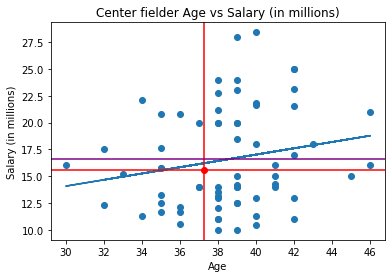

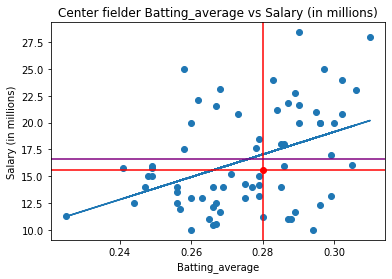

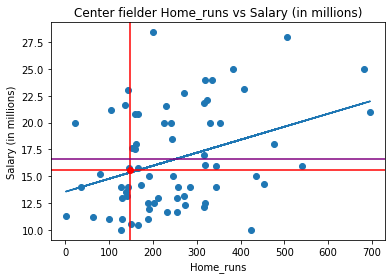

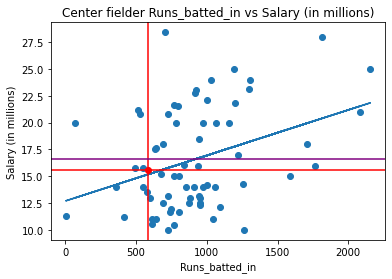



Designated hitter


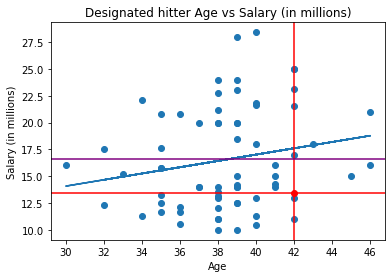

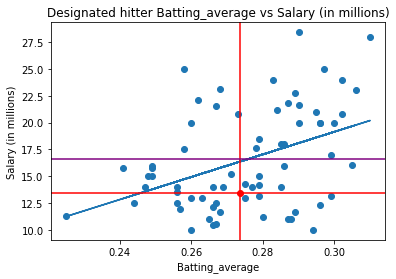

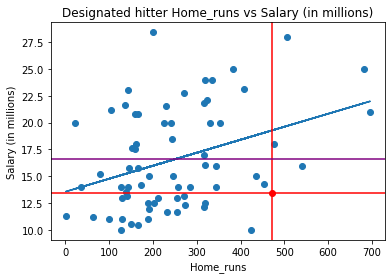

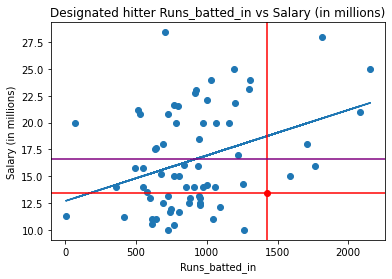



First baseman


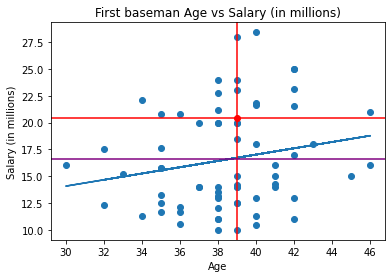

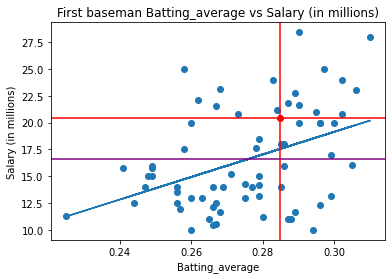

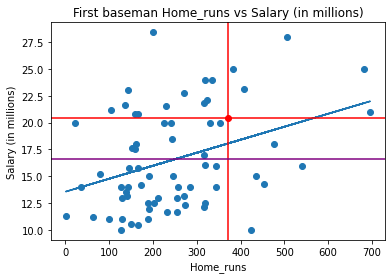

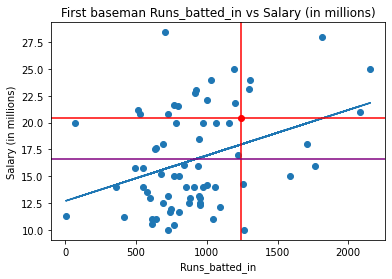



Left fielder


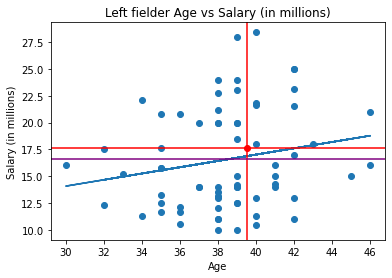

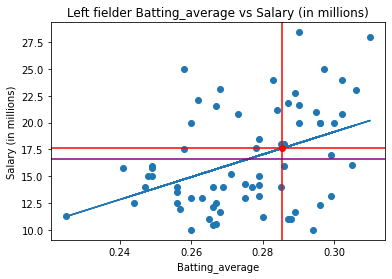

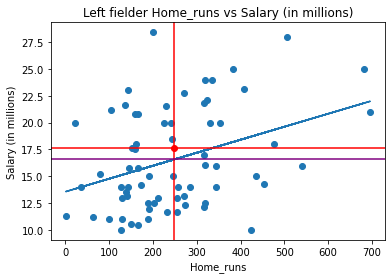

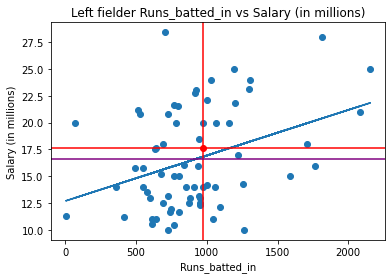



Outfielder


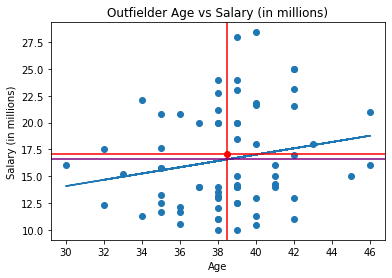

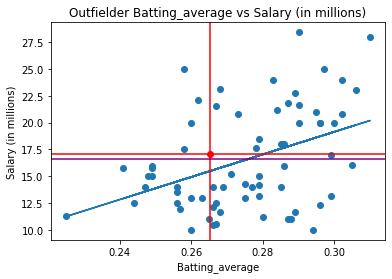

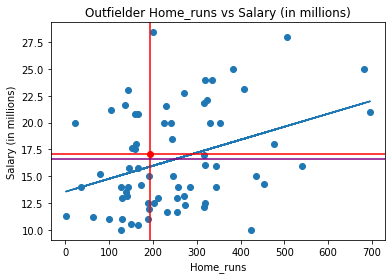

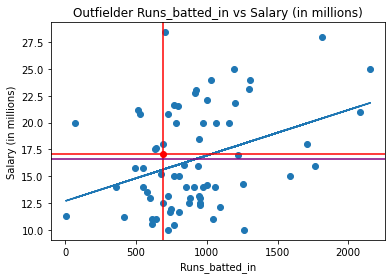



Right fielder


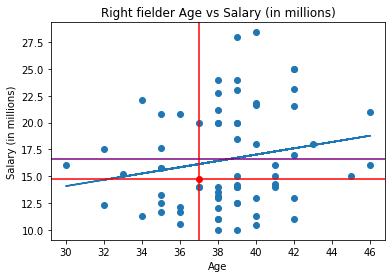

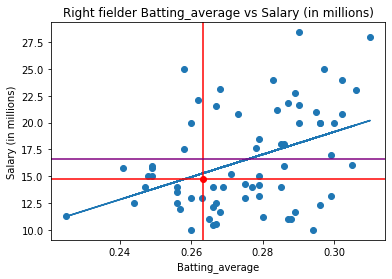

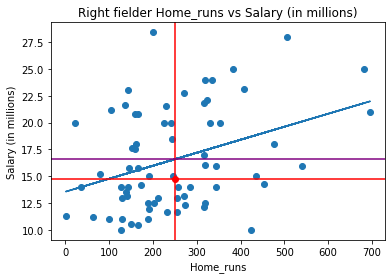

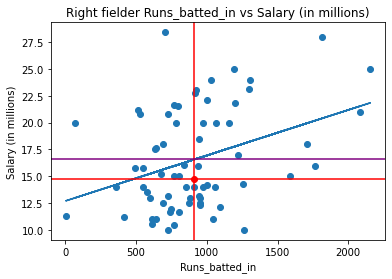



Second baseman


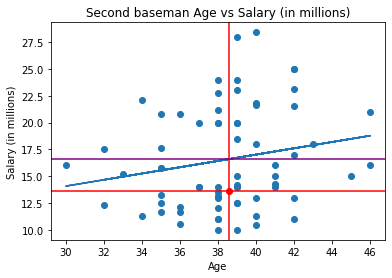

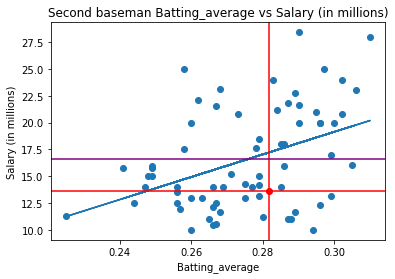

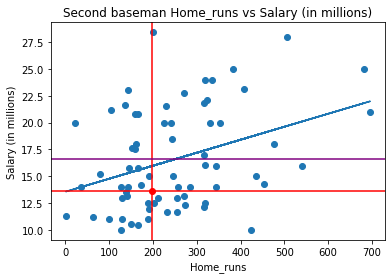

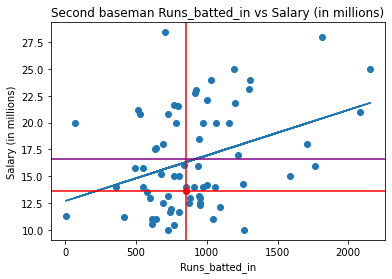



Shortstop


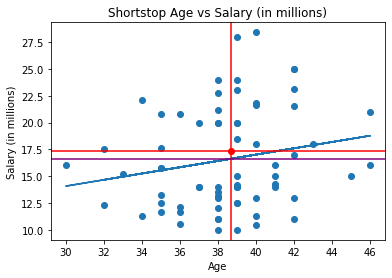

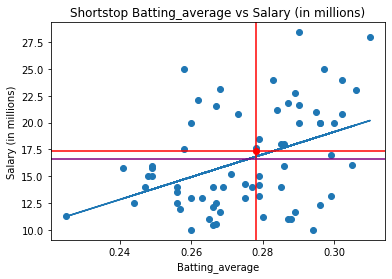

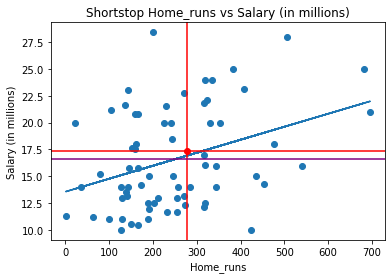

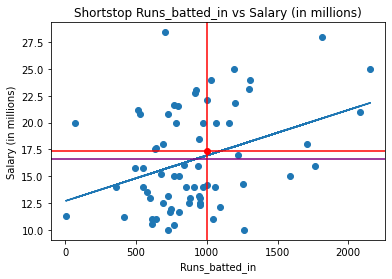



Third baseman


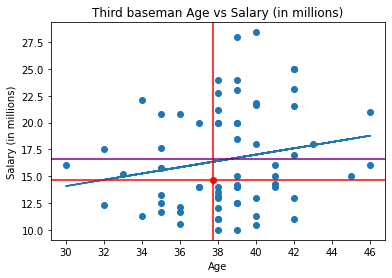

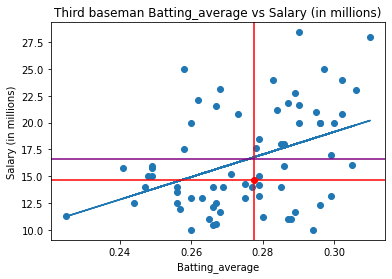

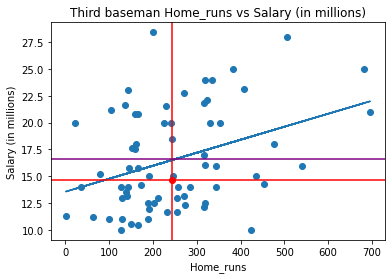

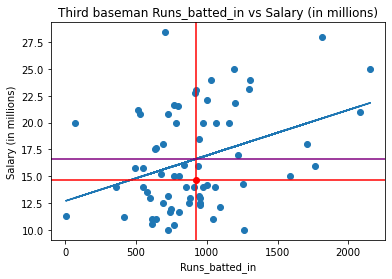

In [38]:
#loop through all of the stats for each of the positions to display their graphs 
stat_list = ['Age', 'Batting_average',	'Home_runs', 'Runs_batted_in']
for i in range(len(avg_player_stats['Position'])):
  position = avg_player_stats['Position'][i]
  print(position)
  for stat in stat_list:
    x = player_stats[stat]
    y = player_stats['Salary']/1000000
    x_label = stat
    y_label = 'Salary (in millions)'
    position = position
    avg_x = avg_player_stats['Avg_' + stat][i]
    avg_y = avg_player_stats['Avg_Salary'][i]/1000000
    #ensure stat exists before plotting
    if(not math.isnan(player_stats[stat][i])):
      create_scatterplot(x, y, x_label, y_label, position, avg_x, avg_y)
  print("\n")
  